In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Intal FoolBox Library**

In [2]:
!pip install foolbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.0 MB/s eta 0:00:00


# **ProjectedGradientDescentAttack**

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


308/308 [==============================] - 3s 9ms/step
Accuracy on clean data: 100.00%
308/308 [==============================] - 2s 5ms/step

Adversarial test data: eps:0.2
Accuracy on adversarial examples: 0.00%


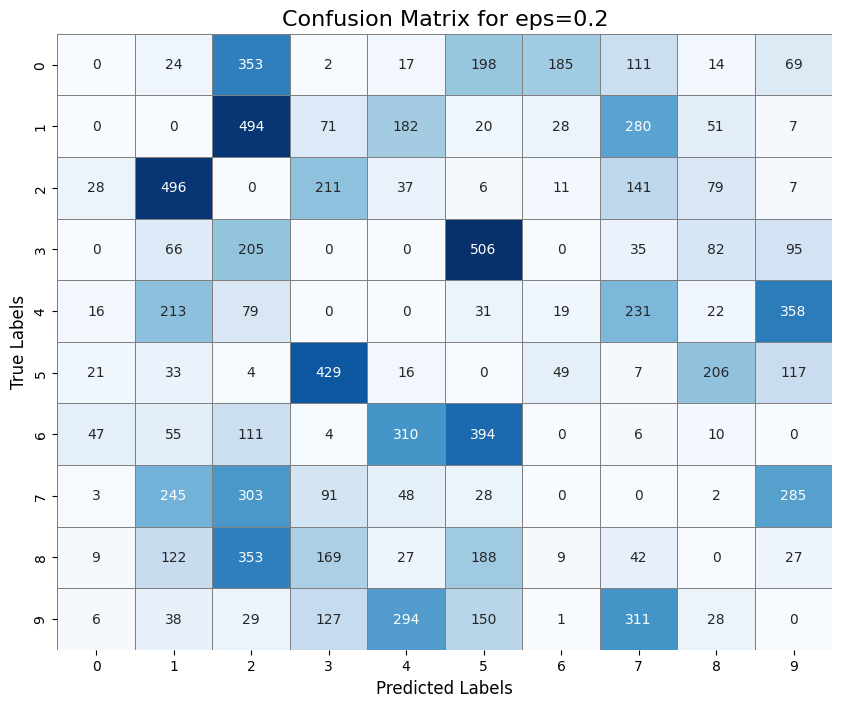

In [3]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import foolbox as fb
import eagerpy as ep
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load your trained model
model = load_model('/content/drive/MyDrive/ColabNotebooks/mnist_model.h5')

# Load and preprocess the examples
correct_examples = np.load('/content/drive/MyDrive/ColabNotebooks/correct_examples.npy')
correct_labels = np.load('/content/drive/MyDrive/ColabNotebooks/correct_labels.npy').astype('int32')  # Cast labels to int32

# Create a Foolbox model
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))



# Calculate accuracy on clean data
linfpgd_predictions = model.predict(correct_examples).argmax(axis=-1)
accuracy_clean = np.mean(linfpgd_predictions == correct_labels)
print(f"Accuracy on clean data: {accuracy_clean * 100:.2f}%")

# Convert data to TensorFlow tensors
images = tf.convert_to_tensor(correct_examples)
labels = tf.convert_to_tensor(correct_labels, dtype=tf.int32)  # Cast labels to int32

# Create a Foolbox model for TensorFlow
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Apply an FGSM attack
attack = fb.attacks.LinfPGD()
epsilons = [0.2]
raw_advs, linfpgd_clipped_advs, linfpgd_success = attack(fmodel, images, labels, epsilons=epsilons)




# Assuming 'clipped_advs' are the adversarial examples for different epsilons
for eps, advs_ in zip(epsilons, linfpgd_clipped_advs):
    # Predict the labels of the adversarial examples
    linfpgd_y_adv = np.argmax(model.predict(advs_), axis=1)

    # Calculate accuracy on adversarial examples
    accuracy_adv = np.mean(linfpgd_y_adv == correct_labels)
    print(f"\nAdversarial test data: eps:{eps}")
    print(f"Accuracy on adversarial examples: {accuracy_adv * 100:.2f}%")

    # Calculate the confusion matrix
    cm_pgd = confusion_matrix(correct_labels, linfpgd_y_adv, labels=range(10))

    # Draw and save the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create a mask for the diagonal elements
    mask = np.eye(len(cm_pgd), dtype=bool)

    # Plot the heatmap for off-diagonal elements using the mask
    sns.heatmap(cm_pgd, mask=mask, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, linewidths=.5, linecolor='grey')

    # Plot the heatmap for diagonal elements using the inverse of the mask
    sns.heatmap(cm_pgd, mask=~mask, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, linewidths=.5, linecolor='grey')

    # Labels, title, and ticks
    label_names = [f'{i}' for i in range(10)]
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('True Labels', fontsize=12)
    ax.set_title(f'Confusion Matrix for eps={eps}', fontsize=16)
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names)

    # Save the plot
    image_filename = f'confusion_matrix_eps_{eps}.png'
    plt.savefig(image_filename, bbox_inches='tight')
    plt.show()  # Display the figure in the notebook


In [5]:
# Calculate and report the robust accuracy
# Convert 'success' to float, and calculate the mean
robust_accuracy = 1 - tf.reduce_mean(tf.cast(linfpgd_success, tf.float32), axis=-1)
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.numpy() * 100:4.1f} %")

robust accuracy for perturbations with
  Linf norm ≤ 0.2   :  0.0 %


In [6]:
linfpgd_accuracies = []

for eps, advs_ in zip(epsilons, linfpgd_clipped_advs):
    # ... existing code ...
    linfpgd_accuracies.append(accuracy_adv * 100)



# **Plotting the bar chart for true label counts and predicted label counts**


308/308 [==============================] - 3s 9ms/step


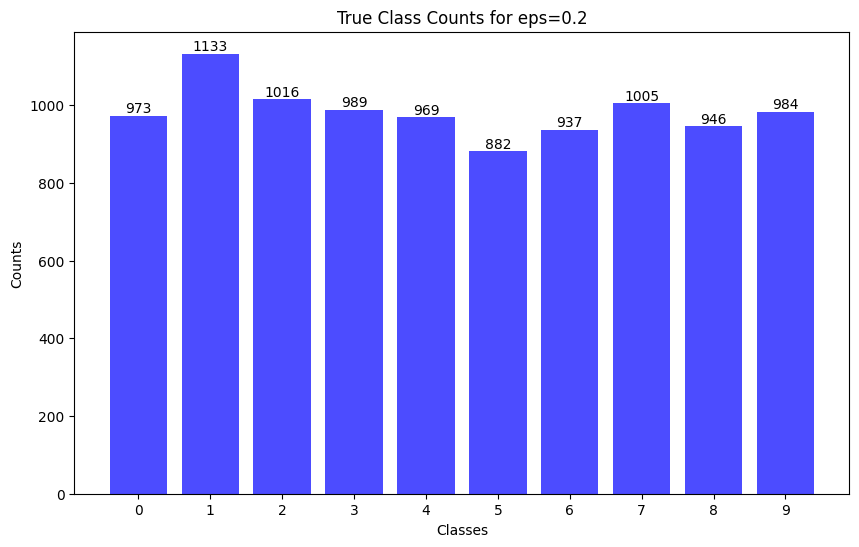

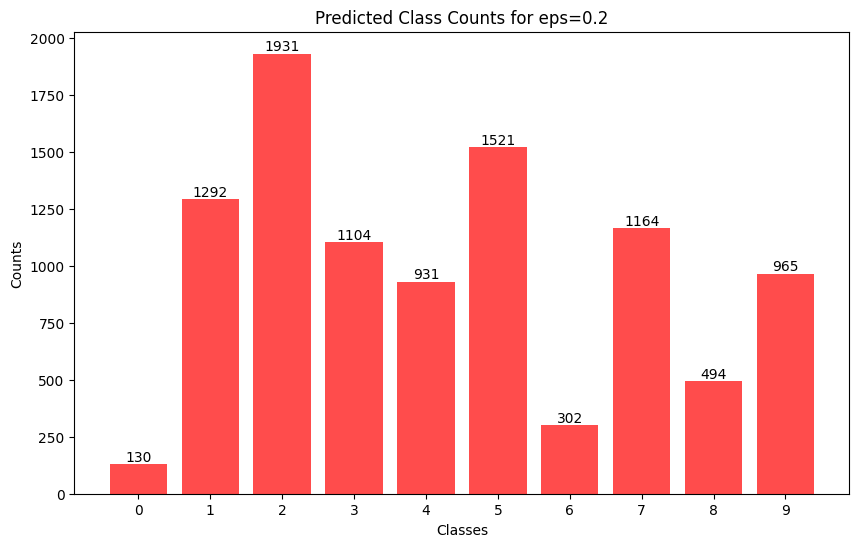

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (other parts of your code) ...

for eps, advs_ in zip(epsilons, linfpgd_clipped_advs):
    # Predict the labels of the adversarial examples
    linfpgd_y_adv = np.argmax(model.predict(advs_), axis=1)

    # Calculate the confusion matrix
    cm = confusion_matrix(correct_labels, linfpgd_y_adv, labels=range(10))

    # Count of each class in true labels
    true_label_counts = np.sum(cm, axis=1)

    # Count of each class in predicted labels
    predicted_label_counts = np.sum(cm, axis=0)

    # Plotting the bar chart for true label counts
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(10), true_label_counts, color='blue', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'True Class Counts for eps={eps}')
    plt.xticks(range(10))

    # Adding count annotations on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()

    # Plotting the bar chart for predicted label counts
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(10), predicted_label_counts, color='red', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'Predicted Class Counts for eps={eps}')
    plt.xticks(range(10))

    # Adding count annotations on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()




# **AdamPGD**

308/308 [==============================] - 3s 9ms/step
Accuracy on clean data: 100.00%
308/308 [==============================] - 2s 6ms/step

Adversarial test data: eps:0.2
Accuracy on adversarial examples: 0.00%


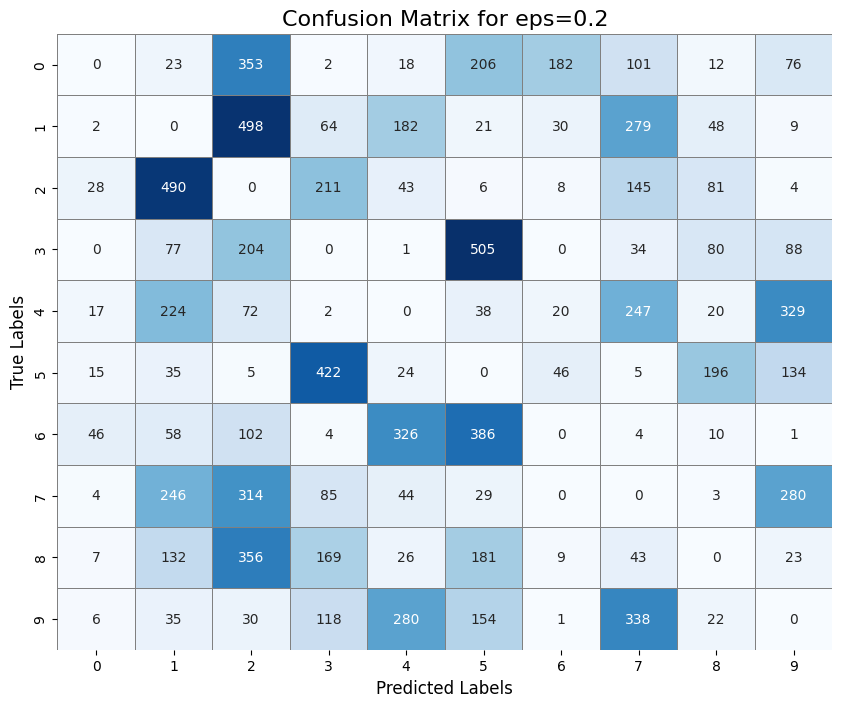

In [8]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import foolbox as fb
import eagerpy as ep
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load your trained model
model = load_model('/content/drive/MyDrive/ColabNotebooks/mnist_model.h5')

# Load and preprocess the examples
correct_examples = np.load('/content/drive/MyDrive/ColabNotebooks/correct_examples.npy')
correct_labels = np.load('/content/drive/MyDrive/ColabNotebooks/correct_labels.npy').astype('int32')  # Cast labels to int32

# Create a Foolbox model
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))



# Calculate accuracy on clean data
adam_predictions = model.predict(correct_examples).argmax(axis=-1)
accuracy_clean = np.mean(adam_predictions == correct_labels)
print(f"Accuracy on clean data: {accuracy_clean * 100:.2f}%")

# Convert data to TensorFlow tensors
images = tf.convert_to_tensor(correct_examples)
labels = tf.convert_to_tensor(correct_labels, dtype=tf.int32)  # Cast labels to int32

# Create a Foolbox model for TensorFlow
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Apply an FGSM attack
attack = fb.attacks.LinfAdamPGD()
epsilons = [0.2]
adam_raw_advs, adam_clipped_advs, adam_success = attack(fmodel, images, labels, epsilons=epsilons)




# Assuming 'clipped_advs' are the adversarial examples for different epsilons
for eps, advs_ in zip(epsilons, adam_clipped_advs):
    # Predict the labels of the adversarial examples
    adam_y_adv = np.argmax(model.predict(advs_), axis=1)

    # Calculate accuracy on adversarial examples
    accuracy_adv = np.mean(adam_y_adv == correct_labels)
    print(f"\nAdversarial test data: eps:{eps}")
    print(f"Accuracy on adversarial examples: {accuracy_adv * 100:.2f}%")

    # Calculate the confusion matrix
    cm_adam = confusion_matrix(correct_labels, adam_y_adv, labels=range(10))

    # Draw and save the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create a mask for the diagonal elements
    mask = np.eye(len(cm_adam), dtype=bool)

    # Plot the heatmap for off-diagonal elements using the mask
    sns.heatmap(cm_adam, mask=mask, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, linewidths=.5, linecolor='grey')

    # Plot the heatmap for diagonal elements using the inverse of the mask
    sns.heatmap(cm_adam, mask=~mask, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, linewidths=.5, linecolor='grey')

    # Labels, title, and ticks
    label_names = [f'{i}' for i in range(10)]
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('True Labels', fontsize=12)
    ax.set_title(f'Confusion Matrix for eps={eps}', fontsize=16)
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names)

    # Save the plot
    image_filename = f'confusion_matrix_eps_{eps}.png'
    plt.savefig(image_filename, bbox_inches='tight')
    plt.show()  # Display the figure in the notebook


308/308 [==============================] - 2s 5ms/step


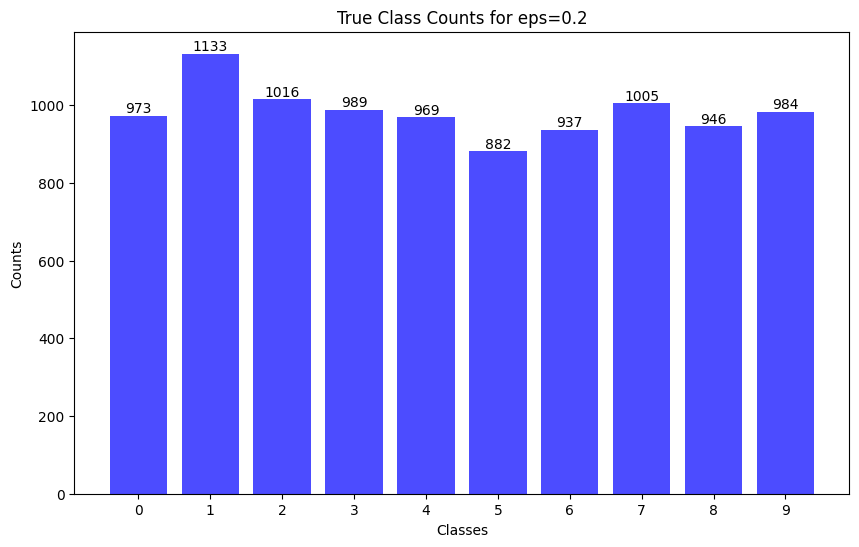

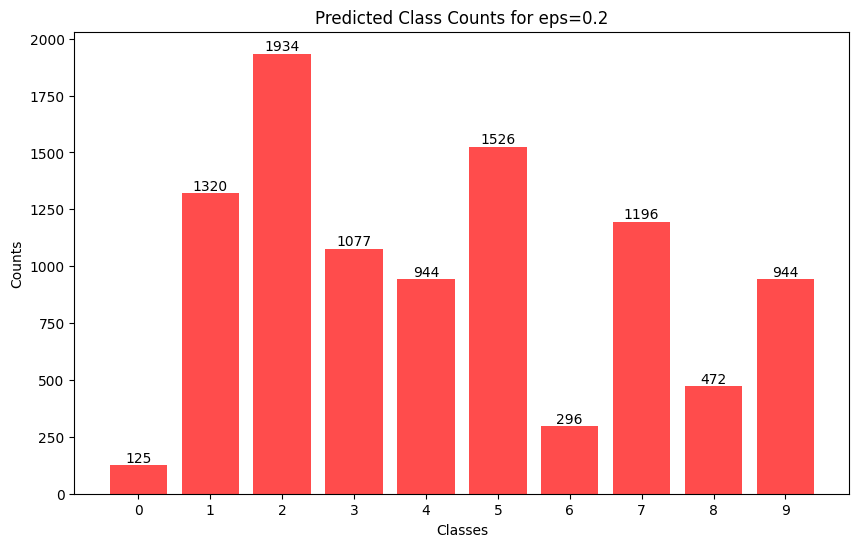

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (other parts of your code) ...

for eps, advs_ in zip(epsilons, adam_clipped_advs):
    # Predict the labels of the adversarial examples
    adam_y_adv = np.argmax(model.predict(advs_), axis=1)

    # Calculate the confusion matrix
    adam_cm = confusion_matrix(correct_labels, adam_y_adv, labels=range(10))

    # Count of each class in true labels
    true_label_counts = np.sum(adam_cm, axis=1)

    # Count of each class in predicted labels
    adam_predicted_label_counts = np.sum(adam_cm, axis=0)

    # Plotting the bar chart for true label counts
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(10), true_label_counts, color='blue', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'True Class Counts for eps={eps}')
    plt.xticks(range(10))

    # Adding count annotations on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()

    # Plotting the bar chart for predicted label counts
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(10), adam_predicted_label_counts, color='red', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'Predicted Class Counts for eps={eps}')
    plt.xticks(range(10))

    # Adding count annotations on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()




# **compare both attacks Predicted Counts in Parellel**

308/308 [==============================] - 3s 9ms/step


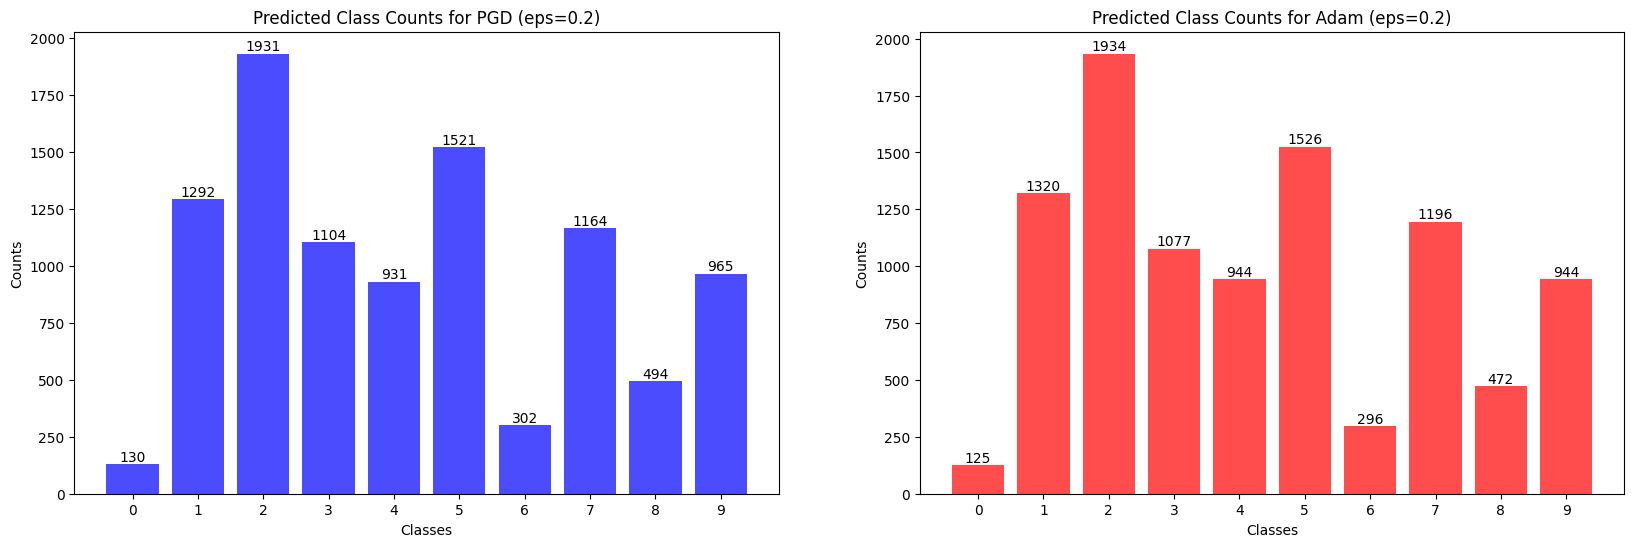

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (other parts of your code) ...

for eps, (advs1_, advs2_) in zip(epsilons, zip(linfpgd_clipped_advs, adam_clipped_advs)):
    # Predict the labels of the adversarial examples for both attacks
    linfpgd_y_adv = np.argmax(model.predict(advs1_), axis=1)
    adam_y_adv = np.argmax(model.predict(advs2_), axis=1)

    # Calculate the confusion matrix for both attacks
    cm1 = confusion_matrix(correct_labels, linfpgd_y_adv, labels=range(10))
    cm2 = confusion_matrix(correct_labels, adam_y_adv, labels=range(10))

    # Count of each class in true labels (assuming it's the same for both attacks)
    true_label_counts = np.sum(cm1, axis=1)

    # Count of each class in predicted labels for both attacks
    predicted_label_counts1 = np.sum(cm1, axis=0)
    predicted_label_counts2 = np.sum(cm2, axis=0)

    # Plotting the bar chart for true label counts
    plt.figure(figsize=(20, 6))

    # Subplot for the first attack
    plt.subplot(1, 2, 1)
    bars = plt.bar(range(10), predicted_label_counts1, color='blue', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'Predicted Class Counts for PGD (eps={eps})')
    plt.xticks(range(10))
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    # Subplot for the second attack
    plt.subplot(1, 2, 2)
    bars = plt.bar(range(10), predicted_label_counts2, color='red', alpha=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(f'Predicted Class Counts for Adam (eps={eps})')
    plt.xticks(range(10))
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

    plt.show()


# **compare both attacks Predicted Counts in one graph**

308/308 [==============================] - 3s 8ms/step


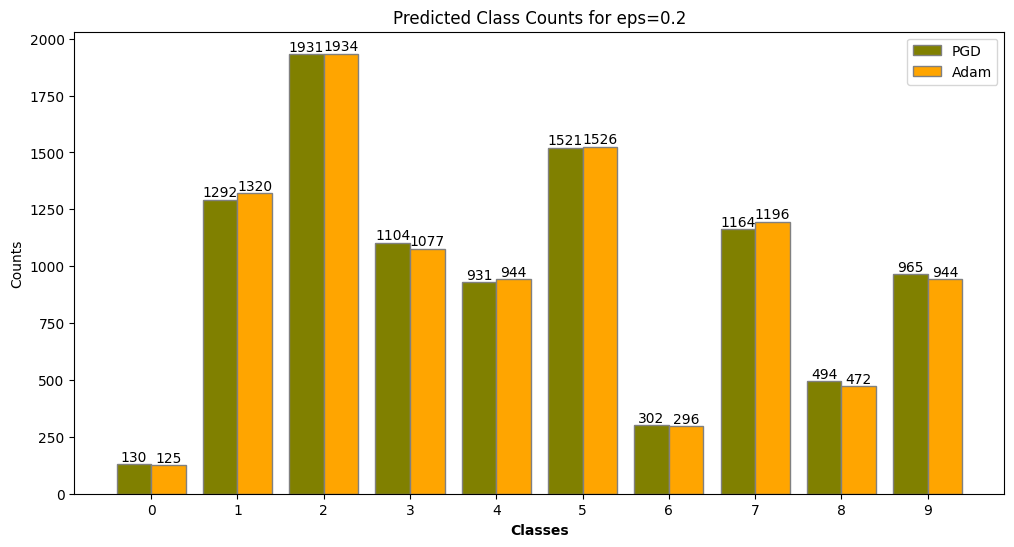

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (other parts of your code) ...

for eps, (advs1_, advs2_) in zip(epsilons, zip(linfpgd_clipped_advs, adam_clipped_advs)):
    # Predict the labels of the adversarial examples for both attacks
    linfpgd_y_adv = np.argmax(model.predict(advs1_), axis=1)
    adam_y_adv = np.argmax(model.predict(advs2_), axis=1)

    # Calculate the confusion matrix for both attacks
    cm1 = confusion_matrix(correct_labels, linfpgd_y_adv, labels=range(10))
    cm2 = confusion_matrix(correct_labels, adam_y_adv, labels=range(10))

    # Count of each class in predicted labels for both attacks
    predicted_label_counts1 = np.sum(cm1, axis=0)
    predicted_label_counts2 = np.sum(cm2, axis=0)

    # Number of classes
    n_classes = range(10)

    # Plotting the grouped bar chart
    plt.figure(figsize=(12, 6))
    bar_width = 0.4  # width of the bars

    # Set position of bar on X axis
    r1 = np.arange(len(predicted_label_counts1))
    r2 = [x + bar_width for x in r1]

    # Make the plot
    plt.bar(r1, predicted_label_counts1, color='olive', width=bar_width, edgecolor='grey', label='PGD')
    plt.bar(r2, predicted_label_counts2, color='orange', width=bar_width, edgecolor='grey', label='Adam')

    # Add labels, title, and legend
    plt.xlabel('Classes', fontweight='bold')
    plt.ylabel('Counts')
    plt.xticks([r + bar_width/2 for r in range(len(predicted_label_counts1))], n_classes)
    plt.title(f'Predicted Class Counts for eps={eps}')
    plt.legend()

    # Adding count annotations on each bar
    for i in range(len(r1)):
        plt.text(r1[i], predicted_label_counts1[i], int(predicted_label_counts1[i]), ha='center', va='bottom')
        plt.text(r2[i], predicted_label_counts2[i], int(predicted_label_counts2[i]), ha='center', va='bottom')

    plt.show()


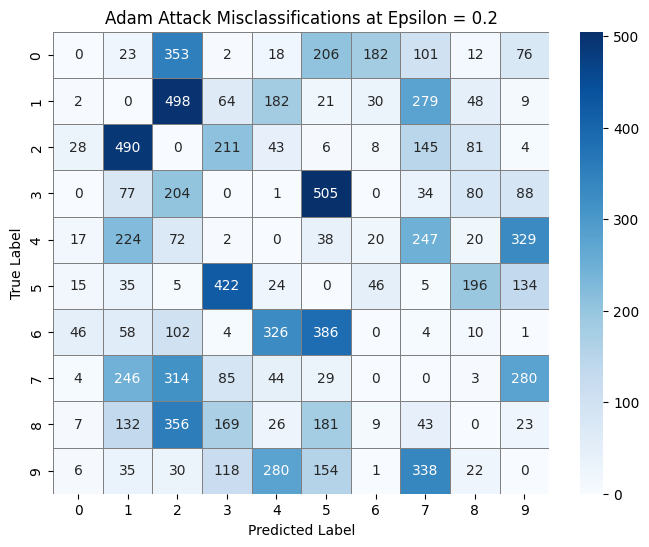

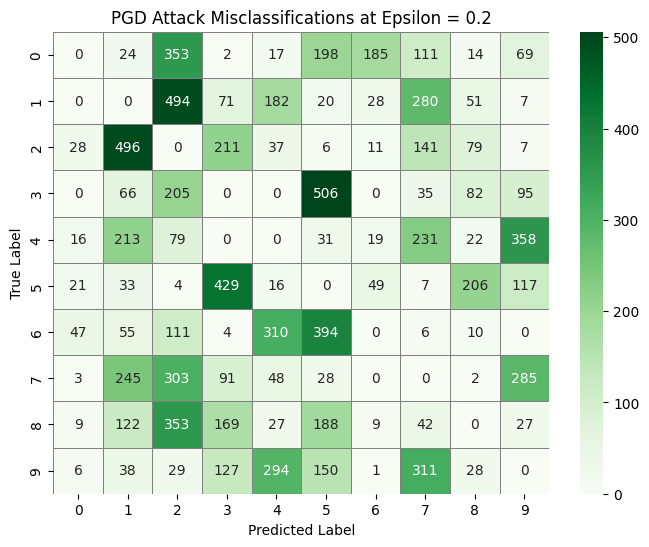

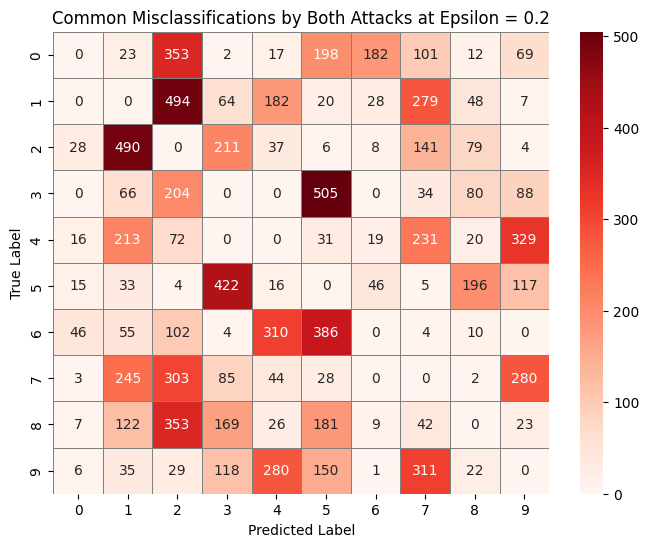

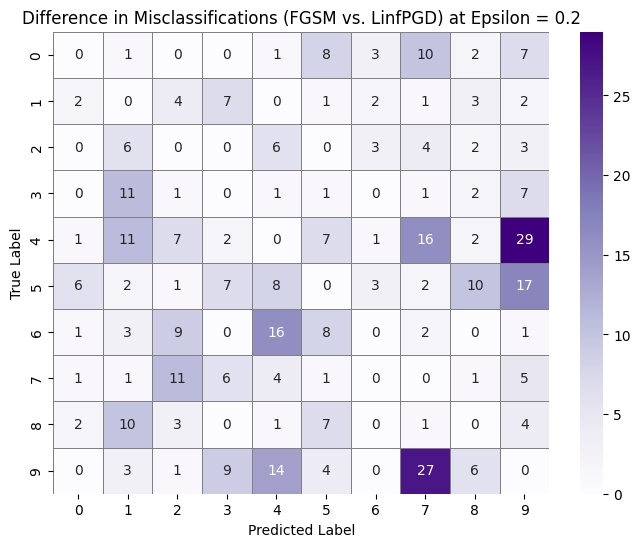

In [12]:
for eps_index, eps in enumerate(epsilons):
    # Assuming you have computed the confusion matrices for FGSM and LinfPGD attacks at each epsilon value
    # cm_fgsm = ... (Computed for FGSM using adversarial examples at eps)
    # cm_linfpgd = ... (Computed for LinfPGD using adversarial examples at eps)

    # Compute common misclassifications
    common_misclassifications = np.minimum(cm_adam, cm_pgd)

    # Compute the absolute difference between the confusion matrices
    cm_difference = np.abs(cm_adam - cm_pgd)

    # Heatmap for FGSM Attack Misclassifications
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_adam, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='gray')
    plt.title(f'Adam Attack Misclassifications at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Heatmap for LinfPGD Attack Misclassifications
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_pgd, annot=True, fmt='d', cmap='Greens', linewidths=.5, linecolor='gray')
    plt.title(f'PGD Attack Misclassifications at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Heatmap for Common Misclassifications by Both Attacks
    plt.figure(figsize=(8, 6))
    sns.heatmap(common_misclassifications, annot=True, fmt='d', cmap='Reds', linewidths=.5, linecolor='gray')
    plt.title(f'Common Misclassifications by Both Attacks at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Heatmap for Differences between Attacks
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_difference, annot=True, fmt='d', cmap='Purples', linewidths=.5, linecolor='gray')
    plt.title(f'Difference in Misclassifications (FGSM vs. LinfPGD) at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [13]:
pip install matplotlib-venn



# **Plotting the bar chart for true label counts and predicted label counts**


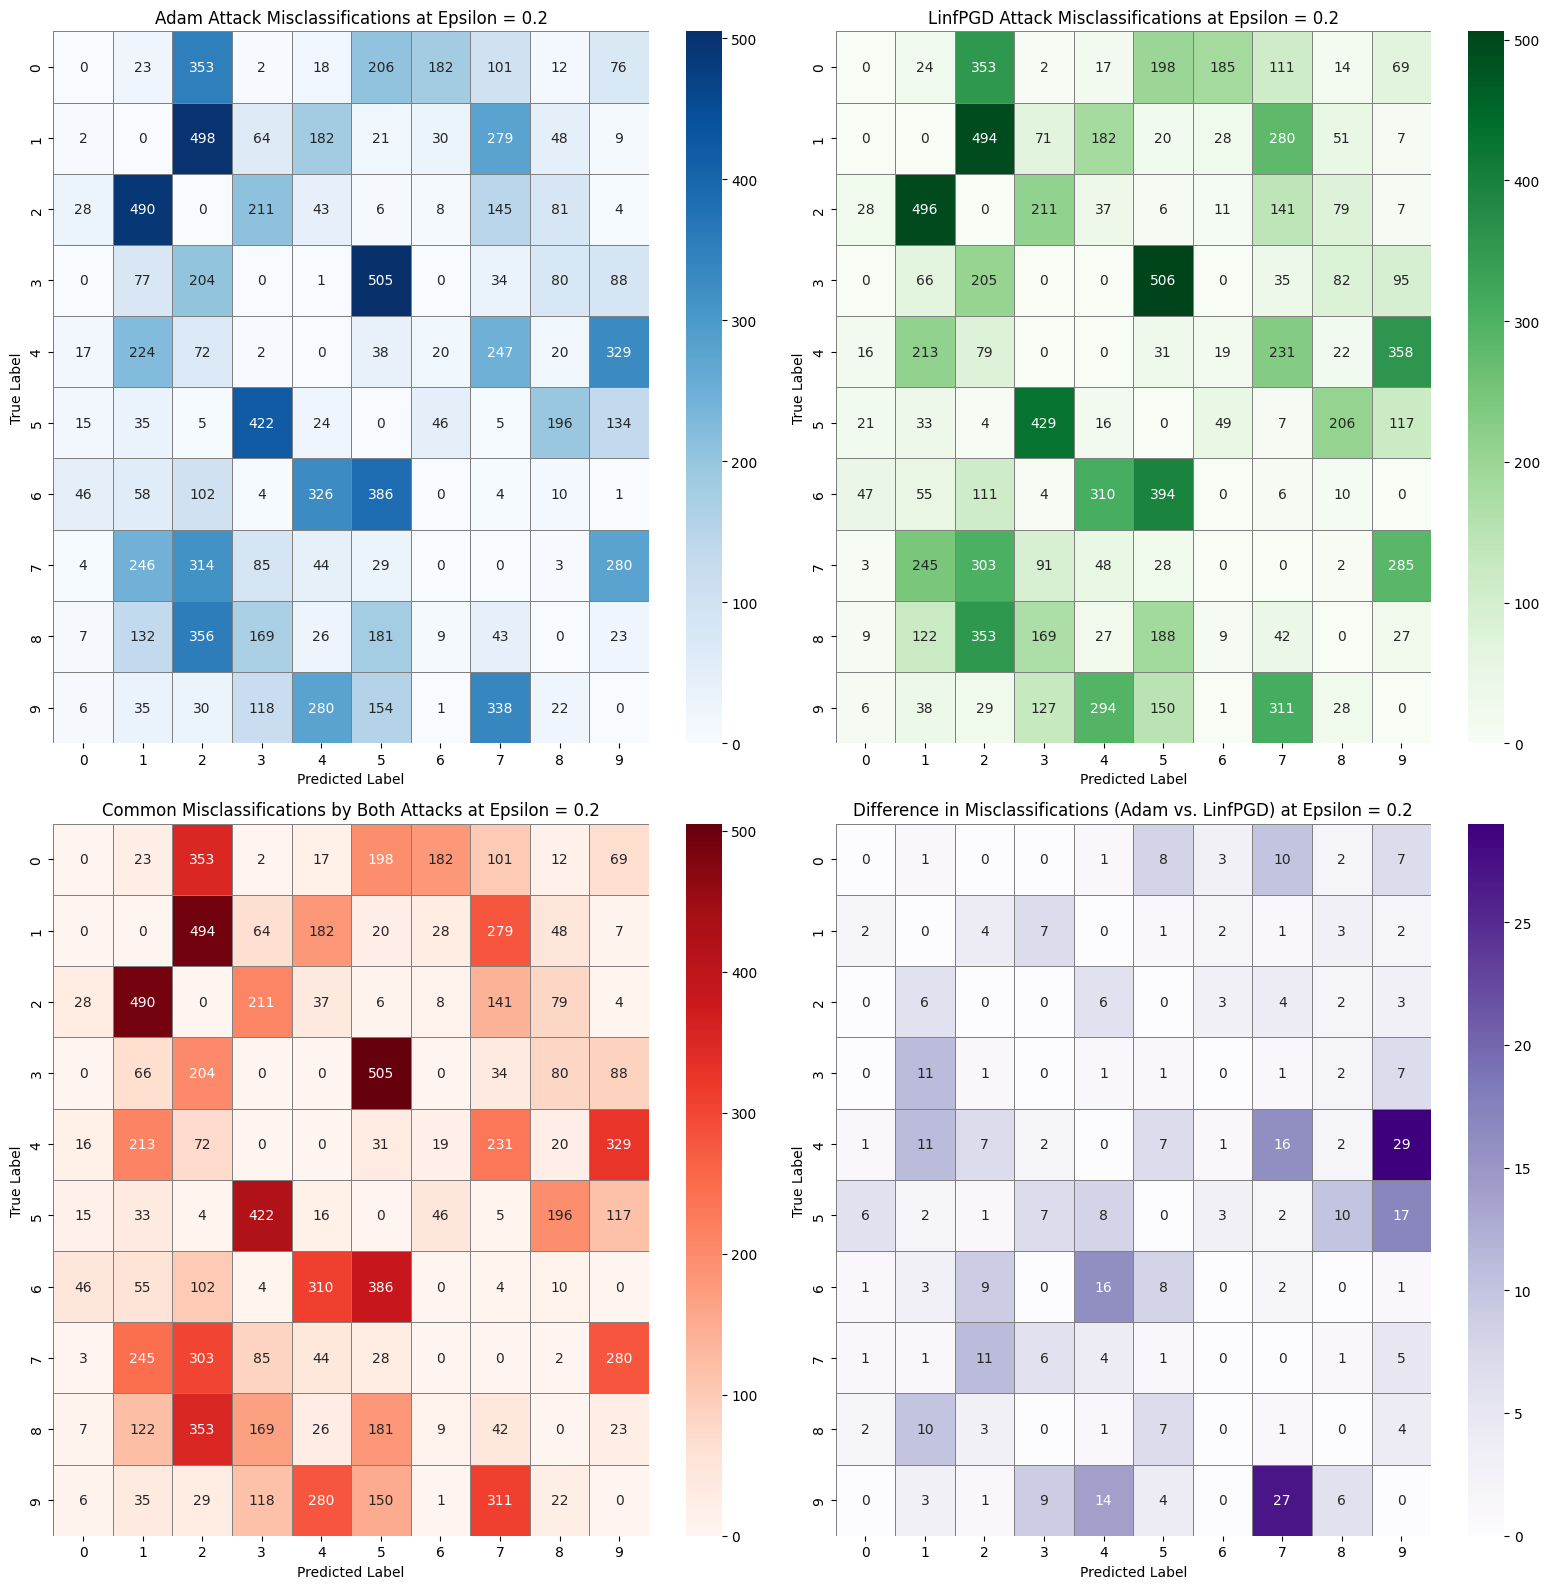

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

for eps_index, eps in enumerate(epsilons):

    # Compute common misclassifications and differences
    common_misclassifications = np.minimum(cm_adam, cm_pgd)
    cm_difference = np.abs(cm_adam - cm_pgd)

    # Create a multi-panel plot
    fig, axs = plt.subplots(2, 2, figsize=(16, 16))

    # Adam Attack Misclassifications
    sns.heatmap(cm_adam, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='gray', ax=axs[0, 0])
    axs[0, 0].set_title(f'Adam Attack Misclassifications at Epsilon = {eps}')
    axs[0, 0].set_ylabel('True Label')
    axs[0, 0].set_xlabel('Predicted Label')

    # LinfPGD Attack Misclassifications
    sns.heatmap(cm_pgd, annot=True, fmt='d', cmap='Greens', linewidths=.5, linecolor='gray', ax=axs[0, 1])
    axs[0, 1].set_title(f'LinfPGD Attack Misclassifications at Epsilon = {eps}')
    axs[0, 1].set_ylabel('True Label')
    axs[0, 1].set_xlabel('Predicted Label')

    # Common Misclassifications by Both Attacks
    sns.heatmap(common_misclassifications, annot=True, fmt='d', cmap='Reds', linewidths=.5, linecolor='gray', ax=axs[1, 0])
    axs[1, 0].set_title(f'Common Misclassifications by Both Attacks at Epsilon = {eps}')
    axs[1, 0].set_ylabel('True Label')
    axs[1, 0].set_xlabel('Predicted Label')

    # Differences between Attacks
    sns.heatmap(cm_difference, annot=True, fmt='d', cmap='Purples', linewidths=.5, linecolor='gray', ax=axs[1, 1])
    axs[1, 1].set_title(f'Difference in Misclassifications (Adam vs. LinfPGD) at Epsilon = {eps}')
    axs[1, 1].set_ylabel('True Label')
    axs[1, 1].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()


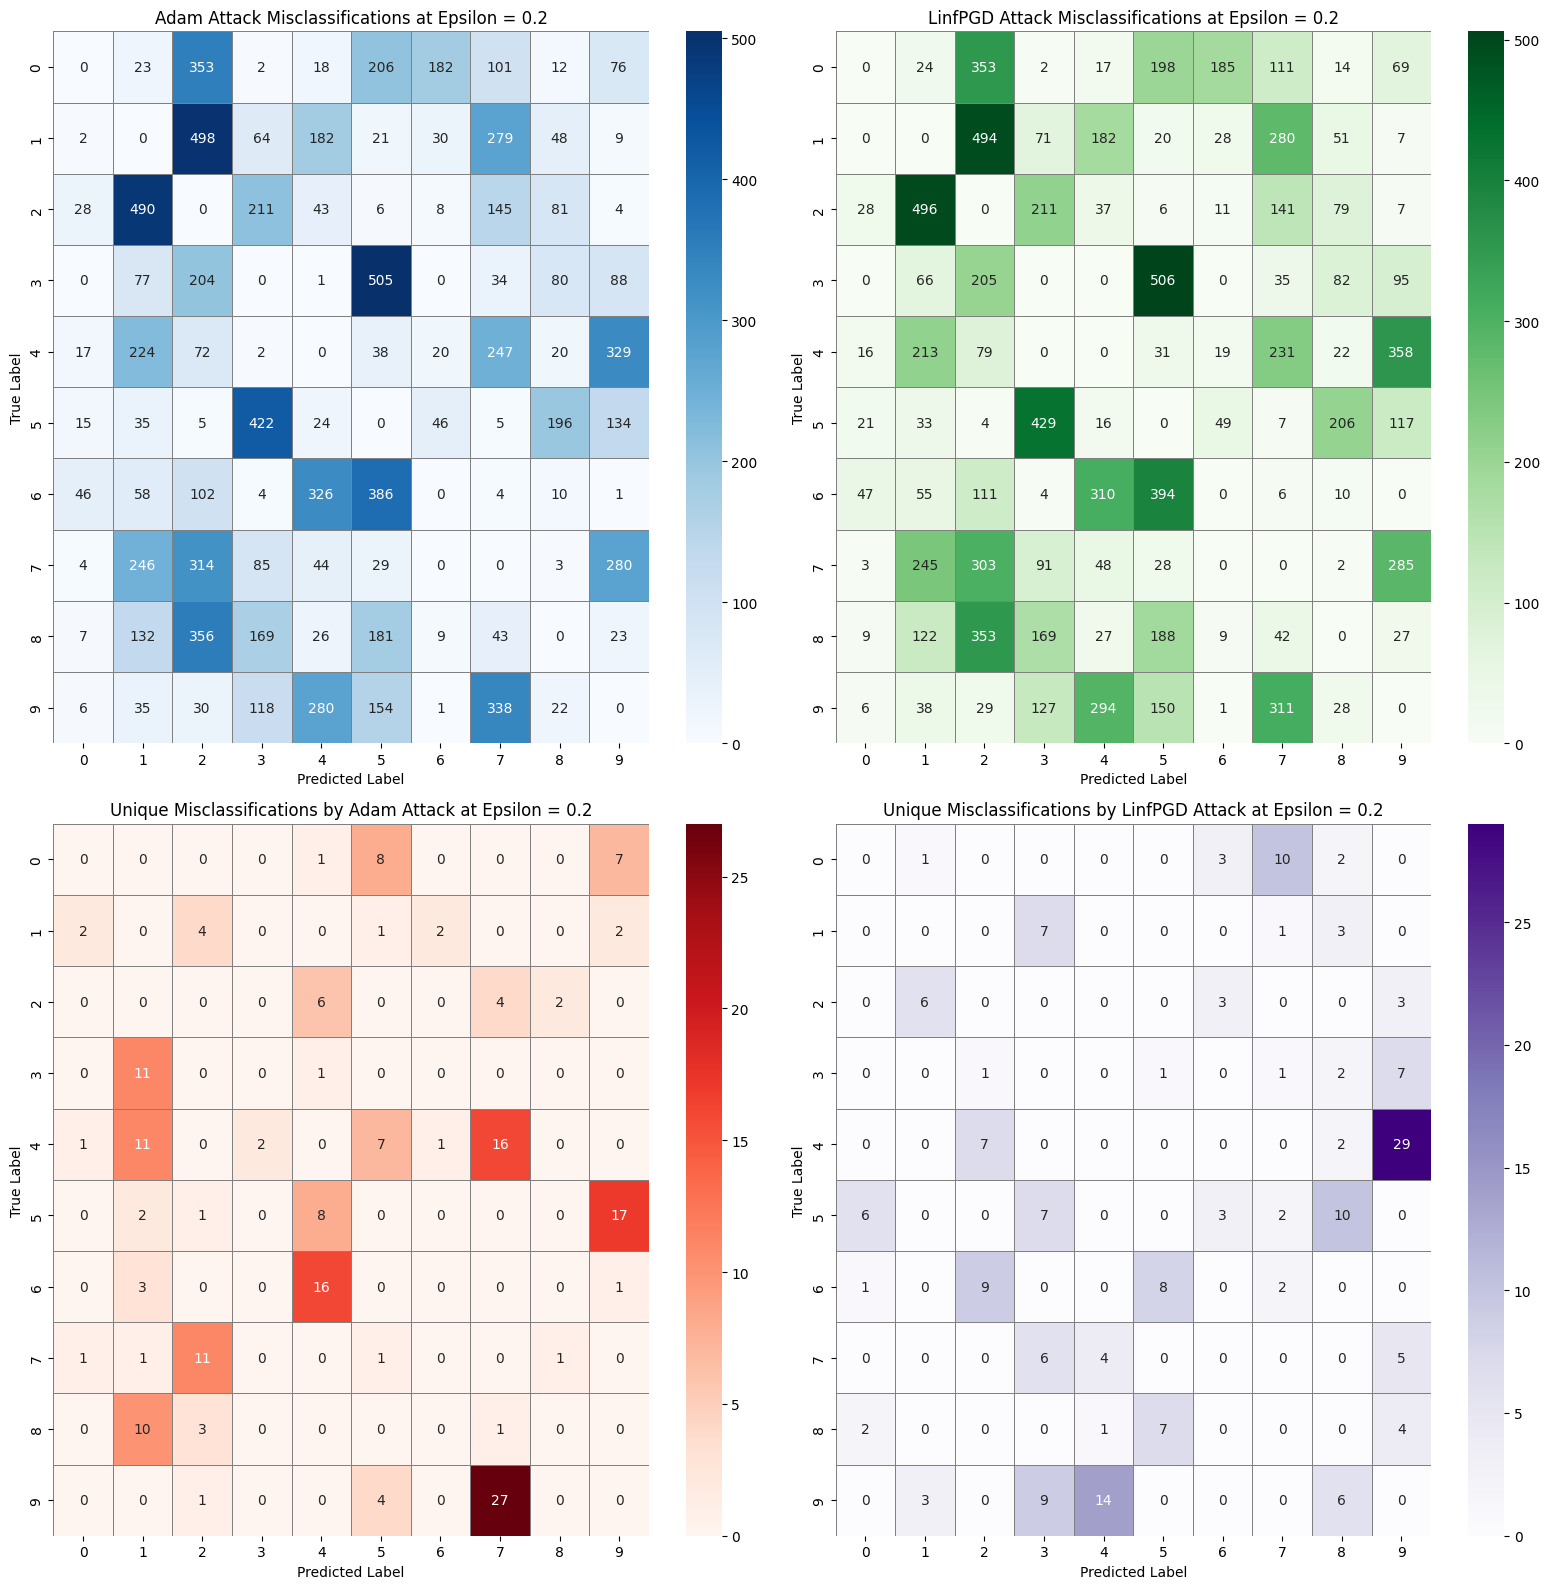

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example epsilons (replace with your actual epsilons)
epsilons = [0.2]

# Example: Loop over different epsilon values
for eps_index, eps in enumerate(epsilons):


    common_misclassifications = np.minimum(cm_adam, cm_linfpgd)
    unique_adam = cm_adam - common_misclassifications
    unique_linfpgd = cm_linfpgd - common_misclassifications

    # Create a multi-panel plot
    fig, axs = plt.subplots(2, 2, figsize=(16, 16))

    # Adam Attack Misclassifications
    sns.heatmap(cm_adam, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='gray', ax=axs[0, 0])
    axs[0, 0].set_title(f'Adam Attack Misclassifications at Epsilon = {eps}')
    axs[0, 0].set_ylabel('True Label')
    axs[0, 0].set_xlabel('Predicted Label')

    # LinfPGD Attack Misclassifications
    sns.heatmap(cm_linfpgd, annot=True, fmt='d', cmap='Greens', linewidths=.5, linecolor='gray', ax=axs[0, 1])
    axs[0, 1].set_title(f'LinfPGD Attack Misclassifications at Epsilon = {eps}')
    axs[0, 1].set_ylabel('True Label')
    axs[0, 1].set_xlabel('Predicted Label')

    # Unique Misclassifications for Adam Attack
    sns.heatmap(unique_adam, annot=True, fmt='d', cmap='Reds', linewidths=.5, linecolor='gray', ax=axs[1, 0])
    axs[1, 0].set_title(f'Unique Misclassifications by Adam Attack at Epsilon = {eps}')
    axs[1, 0].set_ylabel('True Label')
    axs[1, 0].set_xlabel('Predicted Label')

    # Unique Misclassifications for LinfPGD Attack
    sns.heatmap(unique_linfpgd, annot=True, fmt='d', cmap='Purples', linewidths=.5, linecolor='gray', ax=axs[1, 1])
    axs[1, 1].set_title(f'Unique Misclassifications by LinfPGD Attack at Epsilon = {eps}')
    axs[1, 1].set_ylabel('True Label')
    axs[1, 1].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()


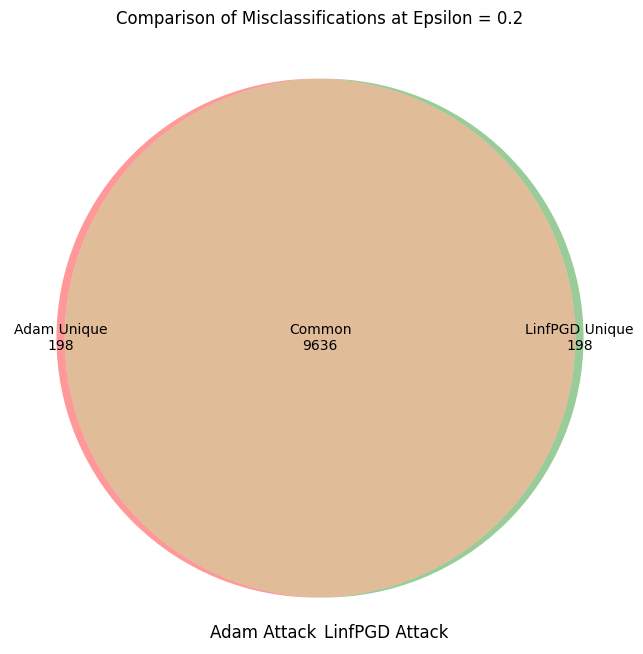

In [44]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np

# ... (your existing code to calculate cm_adam, cm_linfpgd, etc.) ...

for eps_index, eps in enumerate(epsilons):
    # ... (your existing code to calculate common_misclassifications, unique_adam, unique_linfpgd) ...

    # Sum up the counts for the Venn diagram
    total_common = np.sum(common_misclassifications)
    total_unique_adam = np.sum(unique_adam)
    total_unique_linfpgd = np.sum(unique_linfpgd)

    # Create the Venn diagram
    plt.figure(figsize=(8, 8))
    venn = venn2(subsets=(total_unique_adam, total_unique_linfpgd, total_common),
                 set_labels=('Adam Attack', 'LinfPGD Attack'))
    venn.get_label_by_id('10').set_text(f'Adam Unique\n{total_unique_adam}')
    venn.get_label_by_id('01').set_text(f'LinfPGD Unique\n{total_unique_linfpgd}')
    venn.get_label_by_id('11').set_text(f'Common\n{total_common}')
    plt.title(f'Comparison of Misclassifications at Epsilon = {eps}')

    plt.show()


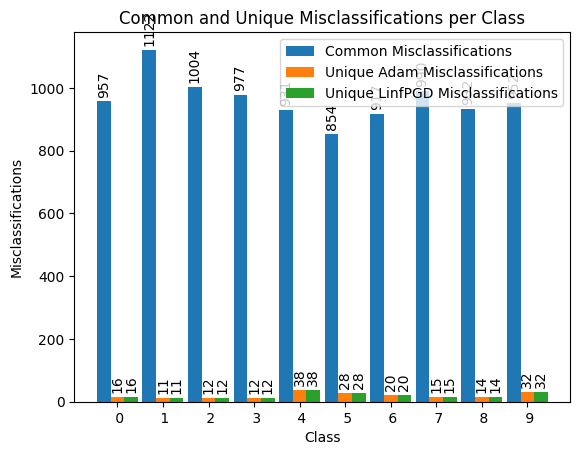

In [34]:
import matplotlib.pyplot as plt
import numpy as np



# Compute common and unique misclassifications
common_misclassifications = np.minimum(cm_adam, cm_pgd)
unique_adam = cm_adam - common_misclassifications
unique_linfpgd = cm_pgd - common_misclassifications

# Sum across rows to get misclassifications for each class
common_counts = np.sum(common_misclassifications, axis=1)
unique_adam_counts = np.sum(unique_adam, axis=1)
unique_linfpgd_counts = np.sum(unique_linfpgd, axis=1)

# Number of classes
n_classes = common_misclassifications.shape[0]

# Set up the bar chart
bar_width = 0.3
index = np.arange(n_classes)

fig, ax = plt.subplots()

bar1 = ax.bar(index, common_counts, bar_width, label='Common Misclassifications')
bar2 = ax.bar(index + bar_width, unique_adam_counts, bar_width, label='Unique Adam Misclassifications')
bar3 = ax.bar(index + 2 * bar_width, unique_linfpgd_counts, bar_width, label='Unique LinfPGD Misclassifications')

# Adding the count above each bar
def add_counts(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',rotation=90)

add_counts(bar1)
add_counts(bar2)
add_counts(bar3)

# Add labels, title, etc.
ax.set_xlabel('Class')
ax.set_ylabel('Misclassifications')
ax.set_title('Common and Unique Misclassifications per Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels([f' {i}' for i in range(n_classes)])
ax.legend()

plt.show()


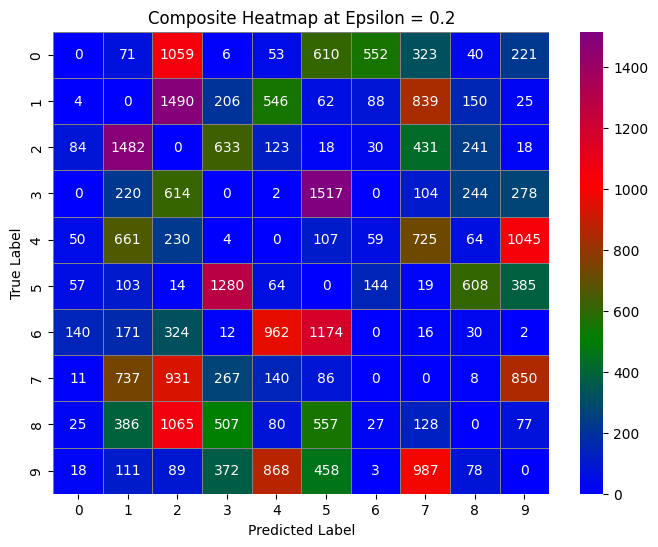

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

for eps_index, eps in enumerate(epsilons):
    # Assuming the confusion matrices are already computed
    common = np.minimum(cm_adam, cm_linfpgd)
    difference = np.abs(cm_adam - cm_linfpgd)

    # Create a composite matrix (this is an example, adjust as needed)
    composite_matrix = cm_adam + cm_linfpgd + common + difference

    # Define a custom colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue", "green", "red", "purple"])

    plt.figure(figsize=(8, 6))
    sns.heatmap(composite_matrix, annot=True, fmt='d', cmap=cmap, linewidths=.5, linecolor='gray')
    plt.title(f'Composite Heatmap at Epsilon = {eps}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
